In [231]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [232]:
import os
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import f1_score
from pathlib import Path
import matplotlib.pyplot as plt
import random
import pandas as pd
from matplotlib import colormaps
import torch.nn.functional as F


from utils.lrp_utils import zennit_relevance  # Import from DFT-LRP utils

import zennit.composites
import zennit.rules
import zennit.core
import zennit.attribution
from zennit.types import Linear

from zennit.composites import LayerMapComposite
from zennit.rules import Epsilon, ZPlus, Pass


In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [48]:
# ------------------------
# 1️⃣ Custom Dataset Class
# ------------------------
class VibrationDataset(Dataset):
    def __init__(self, data_dir):
        self.file_paths = []
        self.labels = []

        for label, label_idx in zip(["good", "bad"], [0, 1]):  # 0=good, 1=bad
            folder = Path(data_dir) / label
            for file_name in os.listdir(folder):
                if file_name.endswith(".h5"):
                    self.file_paths.append(os.path.join(folder, file_name))
                    self.labels.append(label_idx)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        with h5py.File(file_path, "r") as f:
            data = f["vibration_data"][:]  # Shape (10000, 3)

        data = np.transpose(data, (1, 0))  # Change to (3, 10000) for CNN
        label = self.labels[idx]

        return torch.tensor(data, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [135]:
# ------------------------
# 2️⃣ Define the CNN Model
# ------------------------
class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=16, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm1d(16)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64 * 1250, 256)  # Flattened size: (64, 1250)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 2)  # Binary classification (good/bad)

        self.dropout = nn.Dropout(0.3)  # Reduce overfitting
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu(self.bn3(self.conv3(x))))

        x = x.view(x.shape[0], -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # No activation (we use CrossEntropyLoss)

        return x


In [180]:
# ------------------------
# 5️⃣ Full Training Pipeline
# ------------------------
def train_and_evaluate(data_dir, batch_size=32, epochs=20, lr=0.001, train_ratio=0.7, val_ratio=0.15):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load dataset and split into train, val, test sets
    dataset = VibrationDataset(data_dir)
    train_size = int(train_ratio * len(dataset))
    val_size = int(val_ratio * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Model setup
    model = CNN1D().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training and validation loop
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    print("✅ Training and validation complete!")

    # Evaluate on the test set
    f1, accuracy = test_model(model, test_loader, device)
    print(f"🔥 Test F1 Score: {f1:.4f}, Test Accuracy: {accuracy:.4f}")

    return model

In [181]:
# ------------------------
# 3️⃣ Train & Evaluate Functions
# ------------------------
def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    return total_loss / len(train_loader), accuracy


In [182]:
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return total_loss / len(val_loader), accuracy

In [183]:
# ------------------------
# 4️⃣ Test the Model
# ------------------------
def test_model(model, test_loader, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)  # Get predicted class

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute F1-score
    f1 = f1_score(all_labels, all_preds, average="weighted")
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()

    return f1, accuracy


In [184]:
# Splitting the dataset
data_directory = "./data/final/Selected_data_windowed_grouped_normalized"

dataset = VibrationDataset(data_directory)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Creating DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [185]:
# ------------------------
# 5️⃣ Full Training Pipeline
# ------------------------
def train_and_evaluate(train_loader, val_loader, test_loader, epochs=20, lr=0.001):

    '''
        # Load dataset and split into train, val, test sets
    dataset = VibrationDataset(data_dir)
    train_size = int(train_ratio * len(dataset))
    val_size = int(val_ratio * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    '''

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Model setup
    model = CNN1D().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training and validation loop
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    print("✅ Training and validation complete!")

    # Evaluate on the test set
    f1, accuracy = test_model(model, test_loader, device)
    print(f"🔥 Test F1 Score: {f1:.4f}, Test Accuracy: {accuracy:.4f}")

    return model

In [186]:
# ------------------------
# 6️⃣ Run Training & Evaluation
# ------------------------
model = train_and_evaluate(train_loader, val_loader, test_loader)


Epoch [1/20] - Train Loss: 2.9050, Train Acc: 0.7417 - Val Loss: 0.3669, Val Acc: 0.8447
Epoch [2/20] - Train Loss: 0.6138, Train Acc: 0.8792 - Val Loss: 0.1959, Val Acc: 0.9417
Epoch [3/20] - Train Loss: 0.1749, Train Acc: 0.9521 - Val Loss: 0.6254, Val Acc: 0.8835
Epoch [4/20] - Train Loss: 0.1563, Train Acc: 0.9563 - Val Loss: 0.4674, Val Acc: 0.8738
Epoch [5/20] - Train Loss: 0.2149, Train Acc: 0.9375 - Val Loss: 1.1337, Val Acc: 0.8252
Epoch [6/20] - Train Loss: 0.2781, Train Acc: 0.9479 - Val Loss: 0.2417, Val Acc: 0.9417
Epoch [7/20] - Train Loss: 0.0732, Train Acc: 0.9771 - Val Loss: 0.2106, Val Acc: 0.9223
Epoch [8/20] - Train Loss: 0.0326, Train Acc: 0.9812 - Val Loss: 0.1675, Val Acc: 0.9417
Epoch [9/20] - Train Loss: 0.0391, Train Acc: 0.9854 - Val Loss: 0.1238, Val Acc: 0.9806
Epoch [10/20] - Train Loss: 0.0188, Train Acc: 0.9917 - Val Loss: 0.1131, Val Acc: 0.9709
Epoch [11/20] - Train Loss: 0.0046, Train Acc: 0.9979 - Val Loss: 0.1230, Val Acc: 0.9612
Epoch [12/20] - Tra

In [187]:
# Save the trained model
torch.save(model.state_dict(), "cnn1d_model.ckpt")
print("✅ Model saved to cnn1d_model.ckpt")


✅ Model saved to cnn1d_model.ckpt


In [188]:

model.eval()  # Switch to evaluation mode
print("✅ Model loaded and ready for explanations")


✅ Model loaded and ready for explanations


In [189]:
#    Performs a single prediction on input data using the model.
def predict_single(model, x, detach=False):
    """
    Perform a single prediction on input data using the model.
    Args:
        model: Trained PyTorch model.
        x: Input tensor (time-series signal, shape: (3, time_steps)).
        detach: If True, detach the tensor to avoid retaining the computational graph.
    Returns:
        prediction: Model output logits (before softmax).
        ypred: Predicted class label (0 or 1).
    """
    prediction = model.forward(x.unsqueeze(0)).to(device)  # Add batch dimension
    prediction = prediction[0]  # Remove batch dimension

    if detach:
        prediction = prediction.detach()

    ypred = torch.argmax(prediction).item()  # Predicted class

    return prediction, ypred


In [190]:
def visualize_combined_with_label_attribution(signal, attributions, label, method_name, cmap="bwr"):
    """
    Visualize signal with relevance heatmap and relevance over time in a 3x2 grid,
    including the label and average attribution for each axis over time.
    Args:
        signal: Original input signal (shape: (3, time_steps)).
        attributions: Importance values for explanation (shape: (3, time_steps)).
        label: True label for the sample (e.g., "Good" or "Bad").
        method_name: Name of the explanation method (e.g., "Integrated Gradients").
        cmap: Colormap for relevance (default: "bwr").
    """
    def calculate_average_attribution(attributions):
        """
        Calculate the average attribution for each axis.
        Args:
            attributions: Attribution values (shape: (3, time_steps)).
        Returns:
            A list of average attribution values for each axis.
        """
        averages = [np.mean(attr) for attr in attributions]
        return averages

    if isinstance(attributions, torch.Tensor):
        attributions = attributions.detach().cpu().numpy()

    if isinstance(signal, torch.Tensor):
        signal = signal.detach().cpu().numpy()

    # Calculate average attribution for each axis
    avg_attributions = calculate_average_attribution(attributions)

    axes_labels = ["X", "Y", "Z"]
    fig, axs = plt.subplots(3, 2, figsize=(12, 8))  # 3 rows, 2 columns
    label_text = f"Label: {'Good' if label == 0 else 'Bad'}"



    for i in range(3):  # Loop over axes: X, Y, Z
        time_steps = np.arange(signal[i].shape[0])


        # Find the maximum absolute value for the current axis
        max_abs_value = np.max(np.abs(attributions[i]))
        print(f" Maximum Absolute Attribution in Axis {i}: {max_abs_value}")

        # Map attributions to colors using bwr colormap, scaling between -max_abs_value and +max_abs_value
        norm = plt.Normalize(vmin=-max_abs_value, vmax=max_abs_value)
        cmap = colormaps['bwr']

        # Normalize using -max_abs_value to +max_abs_value to keep zero as white
        '''relevance_colors = plt.cm.get_cmap(cmap)((attributions[i] + max_abs_value) / (2 * max_abs_value))



        # Left column: Signal + Relevance Heatmap
        relevance_colors = plt.cm.get_cmap(cmap)((attributions[i] - np.min(attributions[i])) /
                                                 (np.max(attributions[i]) - np.min(attributions[i])))  # Map to colormap'''

        for t in range(len(time_steps) - 1):
            axs[i, 0].axvspan(time_steps[t], time_steps[t + 1],  color=cmap(norm(attributions[i][t])), alpha=0.5)

        axs[i, 0].plot(time_steps, signal[i], color="black", linewidth=0.8, label="Signal")  # Thinner signal line
        axs[i, 0].set_title(f"{method_name} Heatmap for {axes_labels[i]}-Axis\n{label_text}, Average Attribution{avg_attributions[i]:.4f}")
        axs[i, 0].set_xlabel("Time Steps")
        axs[i, 0].set_ylabel("Signal Value")
        axs[i, 0].legend()

        # Right column: Relevance over Time
        axs[i, 1].bar(time_steps, attributions[i], color=["red" if val > 0 else "blue" for val in attributions[i]],
                      alpha=0.8, width=1.0)
        axs[i, 1].set_title(f"{method_name} Relevance Over Time for {axes_labels[i]}-Axis\n{label_text}")
        axs[i, 1].set_xlabel("Time Steps")
        axs[i, 1].set_ylabel("Relevance Value")

    fig.suptitle(f"Explanation for {method_name} - {label_text}", fontsize=16)  # Add overall title with label
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
    plt.show()


In [191]:
def xai_gradient(model, x, target=None):
    """
    Compute gradients for the given input and target.
    Args:
        model: Trained PyTorch model.
        x: Input tensor (time-series signal, shape: (3, time_steps)).
        target: Target class for explanation (default: model's prediction).
    Returns:
        grad: Gradients w.r.t. input.
        target: Target class used for gradient computation.
    """
    x.requires_grad = True  # Enable gradient computation

    y_pred, y = predict_single(model, x)
    if target is None:
        target = y

    # Compute gradients
    grad, = torch.autograd.grad(y_pred[target], x, y_pred[target])
    # WHICH IS EQUIVALENT TO: y_pred[target].backward(y_pred[target]),  grad = x.grad

    return grad, target


In [192]:
def xai_grad_times_input(model, x, target=None):
    """
    Compute Grad*Input explanation for the given input.
    Args:
        model: Trained PyTorch model.
        x: Input tensor (time-series signal, shape: (3, time_steps)).
        target: Target class for explanation (default: model's prediction).
    Returns:
        attribution: Grad*Input attributions.
    """
    grad, target = xai_gradient(model, x, target)

    return grad * x, target  # Multiply gradients by input


In [193]:
def xai_smoothgrad(model, x, num_samples=200, noise_level=3, target=None):
    """
    Compute SmoothGrad explanation for the given input.
    Args:
        model: Trained PyTorch model.
        x: Input tensor (time-series signal, shape: (3, time_steps)).
        num_samples: Number of noisy samples to generate (default: 200).
        noise_level: Standard deviation of added noise (default: 3).
        target: Target class for explanation (default: model's prediction).
    Returns:
        sgrad: SmoothGrad attributions (averaged gradients).
        target: Target class used for explanation.
    """
    # Compute gradients for the original signal
    sgrad, target = xai_gradient(model, x, target)

    # Add noisy samples and accumulate gradients
    for i in range(1, num_samples):
        noisy_x = torch.clone(x.detach()) + torch.randn_like(x) * noise_level
        sgrad += xai_gradient(model, noisy_x, target)[0]

    # Average accumulated gradients
    sgrad /= num_samples

    return sgrad * x, target


In [194]:
def xai_occlusion_signal(model, x, target=None, occlusion_type="zero"):
    """
    Compute occlusion-based explanation for time-series signal.
    Args:
        model: Trained PyTorch model.
        x: Input tensor (time-series signal, shape: (3, time_steps)).
        target: Target class for explanation (default: model's prediction).
        occlusion_type: Type of occlusion ("zero", "one", "mone", "flip").
    Returns:
        attribution: Occlusion-based attributions (3, time_steps).
    """
    def zero(_): return 0
    def one(_): return 1
    def mone(_): return -1
    def flip(val): return -val

    occlusion_fxns = {"zero": zero, "one": one, "mone": mone, "flip": flip}
    assert occlusion_type in occlusion_fxns, f"Invalid occlusion type: {occlusion_type}"

    # Original prediction
    x_0 = x.detach().clone()
    pred_0, y_0 = predict_single(model, x_0, detach=True)
    if target is None:
        target = y_0

    # Prepare attribution mask
    attributions = torch.zeros_like(x)

    # Iterate over time steps and axes
    for feature_idx in range(x.shape[0]):  # X, Y, Z axes
        for time_idx in range(x.shape[1]):  # Time steps
            x_copy = x.clone()
            x_copy[feature_idx, time_idx] = occlusion_fxns[occlusion_type](x_copy[feature_idx, time_idx])
            pred, _ = predict_single(model, x_copy, detach=True)
            attributions[feature_idx, time_idx] = pred_0[target] - pred[target]

    return attributions, target


In [195]:
def xai_occlusion_simple(model, x, target=None, occlusion_type="zero", window_size=200):
    """
    Compute occlusion-based explanation for time-series signals.

    Args:
        model: Trained PyTorch model.
        x: Input tensor (time-series signal, shape: (3, time_steps)).
        target: Target class for explanation (default: model's prediction).
        occlusion_type: Type of occlusion ("zero", "one", "mone", "flip").
        window_size: Number of consecutive time steps to occlude.

    Returns:
        attribution: Occlusion-based attributions (3, time_steps).
    """
    def zero(_): return 0      # Replace occluded time points with 0
    def one(_): return 1       # Replace occluded time points with 1
    def mone(_): return -1     # Replace occluded time points with -1
    def flip(val): return -val # Flip the sign of the original value

    occlusion_fxns = {"zero": zero, "one": one, "mone": mone, "flip": flip}
    assert occlusion_type in occlusion_fxns, f"Invalid occlusion type: {occlusion_type}"

    # Get the original prediction before occlusion
    x_0 = x.detach().clone()
    pred_0, y_0 = predict_single(model, x_0, detach=True)
    if target is None:
        target = y_0  # Use model's prediction if no target is provided

    # Prepare attribution mask (same shape as input)
    attributions = torch.zeros_like(x)

    # Iterate over time steps in window_size chunks
    for i in range(0, x.shape[1], window_size):  # Slide occlusion window
        x_copy = x.clone()  # Copy original input

        for feature_idx in range(x.shape[0]):  # X, Y, Z axes
            x_copy[feature_idx, i:i+window_size] = occlusion_fxns[occlusion_type](x_copy[feature_idx, i:i+window_size])

        # Get new prediction after occlusion
        pred, _ = predict_single(model, x_copy, detach=True)

        # Compute attribution: Difference in target class probability
        attributions[:, i:i+window_size] = pred_0[target] - pred[target]

    return attributions, target


In [196]:
print(model)


CNN1D(
  (conv1): Conv1d(3, 16, kernel_size=(7,), stride=(1,), padding=(3,))
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=80000, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
)


In [197]:
def summarize_attributions(attributions):
    """
    Summarize the positive and negative attributions for each axis, including counts, averages, and totals.
    Args:
        attributions: Attribution values (shape: (3, time_steps)).
    Returns:
        summary: Dictionary with detailed attribution statistics per axis.
    """
    summary = {}
    for axis, attr in enumerate(attributions):
        # Positive relevance
        positive_values = attr[attr > 0]
        positive_count = len(positive_values)
        total_positive_relevance = np.sum(positive_values)
        average_positive_relevance = total_positive_relevance / positive_count if positive_count > 0 else 0

        # Negative relevance
        negative_values = attr[attr < 0]
        negative_count = len(negative_values)
        total_negative_relevance = np.sum(negative_values)
        average_negative_relevance = total_negative_relevance / negative_count if negative_count > 0 else 0

        # Total relevance (positive + negative)
        total_relevance = total_positive_relevance + total_negative_relevance
        total_count = positive_count + negative_count
        average_relevance = total_relevance / total_count if total_count > 0 else 0

        # Store results
        summary[f"Axis {axis}"] = {
            "Positive Count": positive_count,

            "Total Positive Relevance": total_positive_relevance,

            "Average Positive Relevance": average_positive_relevance,

            "Negative Count": negative_count,

            "Total Negative Relevance": total_negative_relevance,

            "Average Negative Relevance": average_negative_relevance,

            "Total Relevance (Pos + Neg)": total_relevance,

            "Average Relevance (Pos + Neg)": average_relevance,
        }
    return summary



In [92]:
# ------------------------
# 1️⃣ Explain with LRP

In [233]:
def compute_lrp_relevance_single_sample(model, sample, label=None, device="cuda" if torch.cuda.is_available() else "cpu"):
    """
    Compute LRP relevances for a single vibration sample.

    Args:
        model: Trained CNN1D model
        sample: Numpy array or torch tensor of shape (3, 10000) for the vibration data
        label: Optional integer label (0 or 1) for the sample. If None, use model prediction as target
        device: Torch device (CPU or CUDA)

    Returns:
        relevance: Numpy array of shape (3, 10000) containing LRP relevances
        input_signal: Numpy array of the input signal (for visualization)
        predicted_label: Predicted label if label is None
    """
    # Ensure sample is a PyTorch tensor with shape (1, 3, 10000)
    if isinstance(sample, np.ndarray):
        sample = torch.tensor(sample, dtype=torch.float32, device=device).unsqueeze(0)  # Add batch dimension and move to device
    else:
        sample = sample.to(device).unsqueeze(0)  # Assume it's already a tensor, add batch dimension and move to device

    model = model.to(device)
    model.eval()

    # If no label provided, use model prediction as target
    if label is None:
        with torch.no_grad():
            outputs = model(sample)
            _, predicted_label = torch.max(outputs, 1)  # Get predicted class (0 or 1)
        target = predicted_label.item()
    else:
        target = label  # Use provided label as target
        target = torch.tensor([target], device=device)  # Ensure target is on the same device

    # Compute LRP relevances using Zennit
    relevance = zennit_relevance(
        input=sample,
        model=model,
        target=target,  # Target is already on the correct device
        attribution_method="lrp",  # Use LRP
        zennit_choice="EpsilonPlus",  # Use EpsilonPlus rule (stable for neural networks)
        rel_is_model_out=True,  # Relevance is model output (logits)
        cuda=(device == "cuda")
    )

    # Remove batch dimension and convert to numpy
    relevance = relevance.squeeze(0).cpu().numpy()  # Shape: (3, 10000)
    input_signal = sample.squeeze(0).cpu().numpy()  # Shape: (3, 10000)

    return relevance, input_signal, target.item() if label is None else label

In [218]:
# 8️⃣ Visualize LRP Relevances for a Single Sample
# ------------------------
def visualize_lrp_relevance_single_sample(signal, relevance, label, sample_idx=0, axes_names=["X", "Y", "Z"]):
    """
    Visualize a single sample's signal and LRP relevance for each axis.

    Args:
        signal: Numpy array of shape (3, 10000) for the time series
        relevance: Numpy array of shape (3, 10000) for LRP relevances
        label: Integer label (0 or 1) for the sample
        sample_idx: Index of the sample (for title, defaults to 0 for single sample)
        axes_names: List of axis names for labeling
    """
    n_axes = signal.shape[0]
    fig, axs = plt.subplots(n_axes, 2, figsize=(12, 4 * n_axes))

    for i in range(n_axes):
        # Plot signal
        axs[i, 0].plot(signal[i], label=f"Signal ({axes_names[i]})")
        axs[i, 0].set_title(f"Signal - Axis {axes_names[i]} (Sample {sample_idx}, Label: {'Good' if label == 0 else 'Bad'})")
        axs[i, 0].set_xlabel("Time Step")
        axs[i, 0].set_ylabel("Amplitude")
        axs[i, 0].legend()

        # Plot relevance (positive in blue, negative in red)
        axs[i, 1].fill_between(range(len(relevance[i])), relevance[i], where=relevance[i] > 0, color='blue', alpha=0.5, label='Positive Relevance')
        axs[i, 1].fill_between(range(len(relevance[i])), relevance[i], where=relevance[i] < 0, color='red', alpha=0.5, label='Negative Relevance')
        axs[i, 1].set_title(f"LRP Relevance - Axis {axes_names[i]}")
        axs[i, 1].set_xlabel("Time Step")
        axs[i, 1].set_ylabel("Relevance")
        axs[i, 1].legend()

    plt.tight_layout()
    plt.show()

In [227]:
# Load a Good sample

# Load a batch
sample_batch, label_batch = next(iter(train_loader))

# Choose a random index
random_index = random.randint(0, len(sample_batch) - 1)


# Select the random sample and its corresponding label
sample = sample_batch[random_index]  # Shape: (3, 10000)
label = label_batch[random_index]    # Shape: ()



sample = sample.to(device)
label = label.to(device)

_, predicted_label = predict_single(model, sample)


# Print the selected sample and label
print(f"Random Index: {random_index}, Predicted_label:{predicted_label}")
print(label, sample, label.shape, sample.shape)


Random Index: 24, Predicted_label:0
tensor(0, device='cuda:0') tensor([[-0.2821, -0.1506, -0.1234,  ..., -0.1642,  0.2282,  0.1216],
        [ 0.2930,  0.0856, -0.4305,  ..., -0.0612, -2.0295, -0.4508],
        [ 0.3433, -0.0461, -1.1384,  ...,  0.2958, -0.0176,  0.5000]],
       device='cuda:0') torch.Size([]) torch.Size([3, 10000])


In [237]:
print(f"Sample device: {sample.device}")
print(f"Model device: {next(model.parameters()).device}")
# print(f"Target device: {target.device}")
# Compute LRP relevances for the single sample
relevance, input_signal, final_label = compute_lrp_relevance_single_sample(
            model=model,
            sample=sample,  # Shape: (3, 10000) or torch tensor
            label=label,  # Optional: Provide the true label (0 or 1)
            device=device)

print(f"Sample {random_index} Label: {'Good' if final_label == 0 else 'Bad'}")#%%


Sample device: cuda:0
Model device: cuda:0


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [71]:
# Load a Bad sample

# Load a batch
sample_batch, label_batch = next(iter(train_loader))

# Choose a random index
random_index_b = random.randint(0, len(sample_batch) - 1)

# Select the random sample and its corresponding label
sample_b = sample_batch[random_index_b]  # Shape: (3, 10000)
label_b = label_batch[random_index_b]    # Shape: ()



sample_b = sample_b.to(device)
label_b = label_b.to(device)

_, predicted_label_b = predict_single(model, sample_b)


# Print the selected sample and label
print(f"Random Index: {random_index_b}, Predicted_label:{predicted_label_b}")
print(label_b, sample_b, label_b.shape, sample_b.shape)


Random Index: 17, Predicted_label:1
tensor(1, device='cuda:0') tensor([[ 0.0989,  0.1125,  0.1170,  ..., -0.0576,  0.1080,  0.1261],
        [-1.1339, -2.1509, -1.1541,  ..., -1.3312,  0.8193,  2.6459],
        [-0.2218,  0.2768,  1.0557,  ...,  0.6473,  1.3786,  0.4715]],
       device='cuda:0') torch.Size([]) torch.Size([3, 10000])


In [102]:

# LRP_rule_based
lrp_rule_attr = LRP_CNN1D(model)

print(f"Min relevance: {np.min(lrp_rule_attr)}, Max relevance: {np.max(lrp_rule_attr)}")
visualize_combined_with_label_attribution(sample, lrp_rule_attr, label, "Gradient*Input")


Min relevance: LRP_CNN1D(
  (conv1): LRP_Conv1D(3, 16, kernel_size=(7,), stride=(1,), padding=(3,))
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): LRP_MaxPool1D(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): LRP_Conv1D(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): LRP_MaxPool1D(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): LRP_Conv1D(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): LRP_MaxPool1D(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): LRP_FC(in_features=80000, out_features=256, bias=True)
  (fc2): LRP_FC(in_features=256, out_features=64, bias=True)
  (fc3): LRP_FC(in_features=64, out_features=2, bias=True)
), Max relevance: LRP_CNN1D(


TypeError: 'LRP_CNN1D' object is not iterable

Min relevance: -0.2625202536582947, Max relevance: 0.22816890478134155
 Maximum Absolute Attribution in Axis 0: 0.2183663249015808
 Maximum Absolute Attribution in Axis 1: 0.2625202536582947
 Maximum Absolute Attribution in Axis 2: 0.22816890478134155


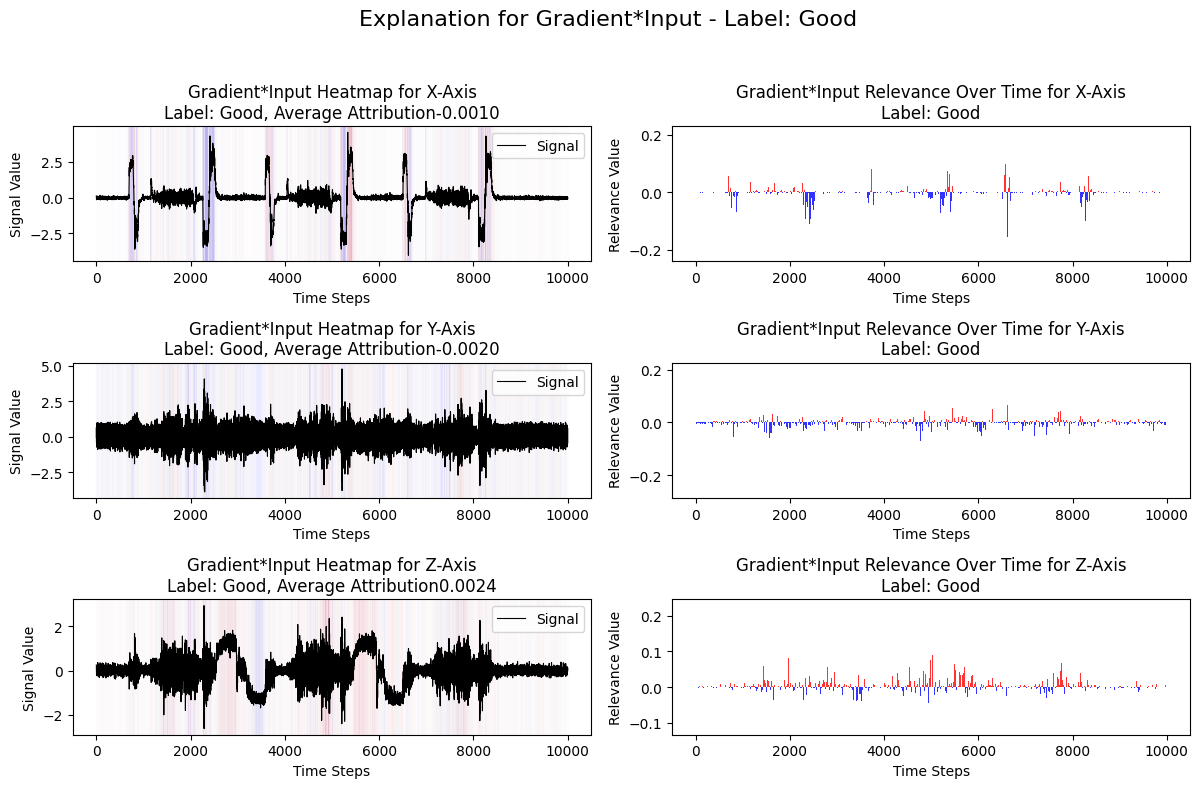

In [72]:

# Grad*Input
grad_input_attr, _ = xai_grad_times_input(model, sample)

print(f"Min relevance: {np.min(grad_input_attr.detach().cpu().numpy())}, Max relevance: {np.max(grad_input_attr.detach().cpu().numpy())}")
visualize_combined_with_label_attribution(sample, grad_input_attr, label, "Gradient*Input")


In [238]:
# Example usage
summary_g = summarize_attributions(grad_input_attr.detach().cpu().numpy())  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_g = []
for axis, values in summary_g.items():
    row = {"Axis": axis}
    row.update(values)
    data_g.append(row)

# Create the DataFrame
df_summary_g = pd.DataFrame(data_g)

# Display the DataFrame as a table
print(df_summary_g)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0            4996                 31.098108   
1  Axis 1            4686                 37.628517   
2  Axis 2            5743                 51.231308   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.006225            5004                -40.873814   
1                    0.008030            5314                -57.164833   
2                    0.008921            4257                -26.940432   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.008168                    -9.775705   
1                   -0.010757                   -19.536316   
2                   -0.006329                    24.290876   

   Average Relevance (Pos + Neg)  
0                      -0.000978  
1                      -0.001954  
2                       0.002429  


Min relevance: -0.27573060989379883, Max relevance: 0.2529065012931824
 Maximum Absolute Attribution in Axis 0: 0.27573060989379883
 Maximum Absolute Attribution in Axis 1: 0.1873462051153183
 Maximum Absolute Attribution in Axis 2: 0.2529065012931824


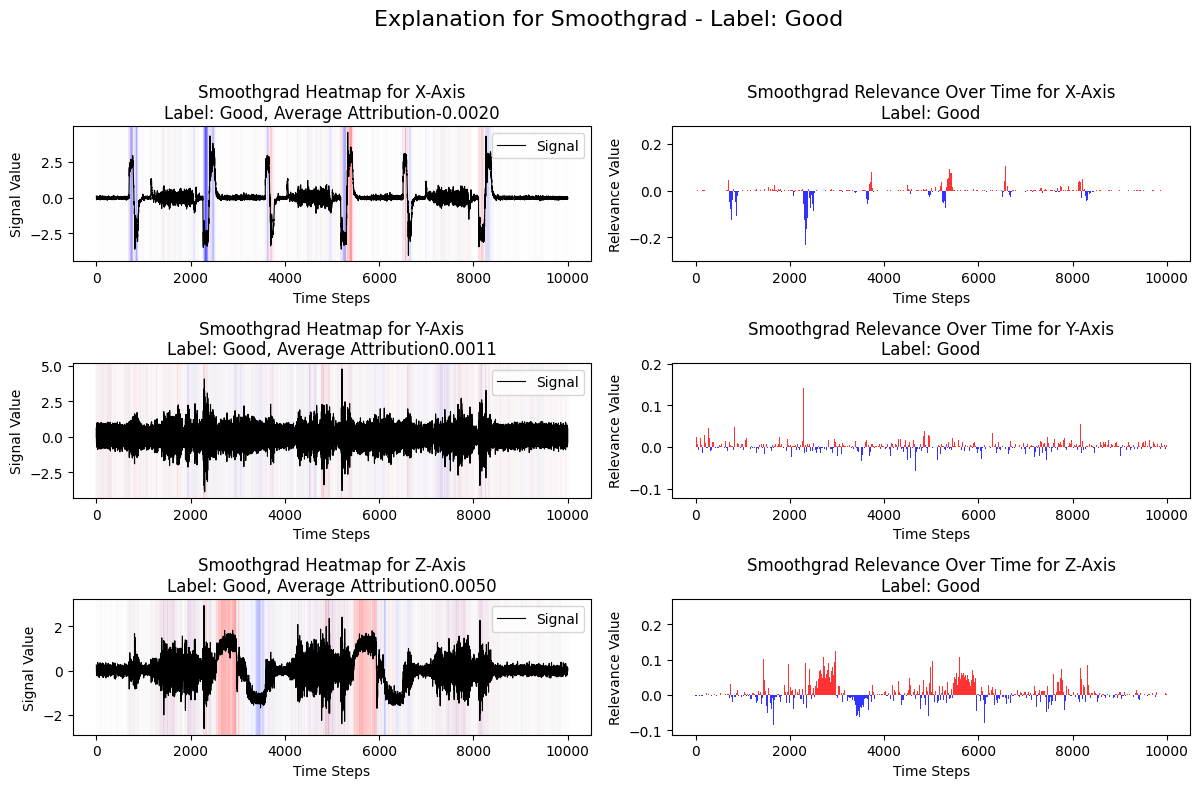

In [74]:
# SmoothGrad
smoothgrad_attr, _ = xai_smoothgrad(model, sample)
print(f"Min relevance: {np.min(smoothgrad_attr.detach().cpu().numpy())}, Max relevance: {np.max(smoothgrad_attr.detach().cpu().numpy())}")
visualize_combined_with_label_attribution(sample, smoothgrad_attr, label, "Smoothgrad")


Min relevance: -0.016658782958984375, Max relevance: 0.016040802001953125
 Maximum Absolute Attribution in Axis 0: 0.014375686645507812
 Maximum Absolute Attribution in Axis 1: 0.016658782958984375
 Maximum Absolute Attribution in Axis 2: 0.016040802001953125


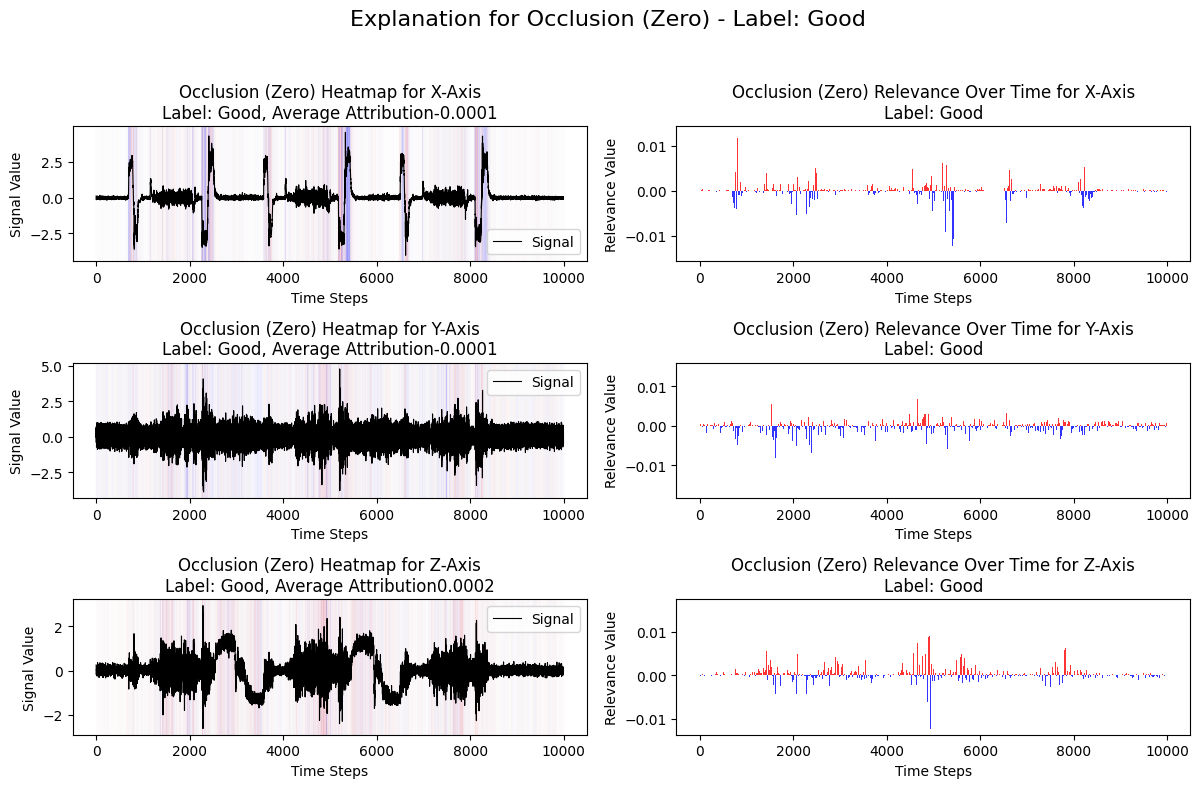

In [75]:
# Occlusion (zero-based occlusion)
occlusion_attr_zero, _ = xai_occlusion_signal(model, sample, occlusion_type="zero")
print(f"Min relevance: {np.min(occlusion_attr_zero.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_zero.detach().cpu().numpy())}")
visualize_combined_with_label_attribution(sample, occlusion_attr_zero, label, "Occlusion (Zero)")


Min relevance: -0.6616420745849609, Max relevance: 0.44643115997314453
 Maximum Absolute Attribution in Axis 0: 0.6616420745849609
 Maximum Absolute Attribution in Axis 1: 0.6616420745849609
 Maximum Absolute Attribution in Axis 2: 0.6616420745849609


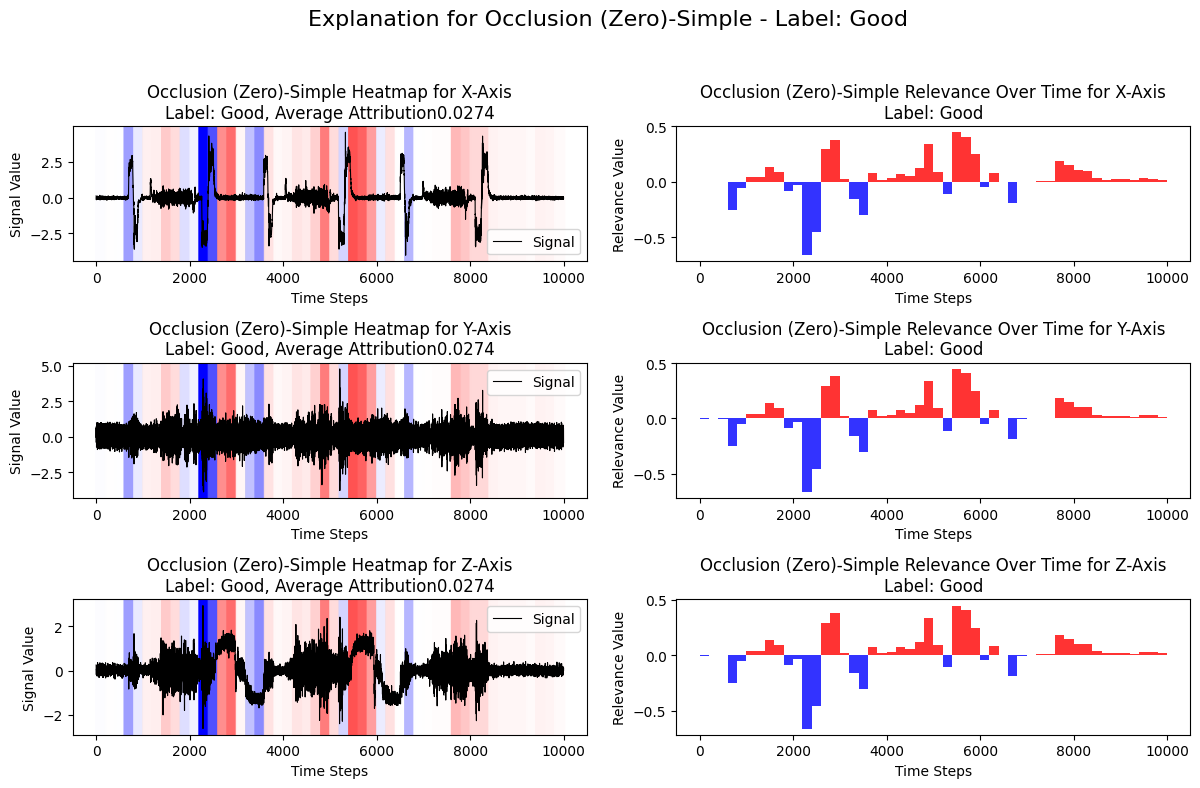

In [95]:
# Occlusion (zero-based occlusion)
occlusion_attr_zero_simple, _ = xai_occlusion_simple(model, sample, occlusion_type="zero")
print(f"Min relevance: {np.min(occlusion_attr_zero_simple.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_zero_simple.detach().cpu().numpy())}")
visualize_combined_with_label_attribution(sample, occlusion_attr_zero_simple, label, "Occlusion (Zero)-Simple")


Min relevance: -0.8896760940551758, Max relevance: 0.5284137725830078
 Maximum Absolute Attribution in Axis 0: 0.8896760940551758
 Maximum Absolute Attribution in Axis 1: 0.8896760940551758
 Maximum Absolute Attribution in Axis 2: 0.8896760940551758


C:\Users\asadi\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


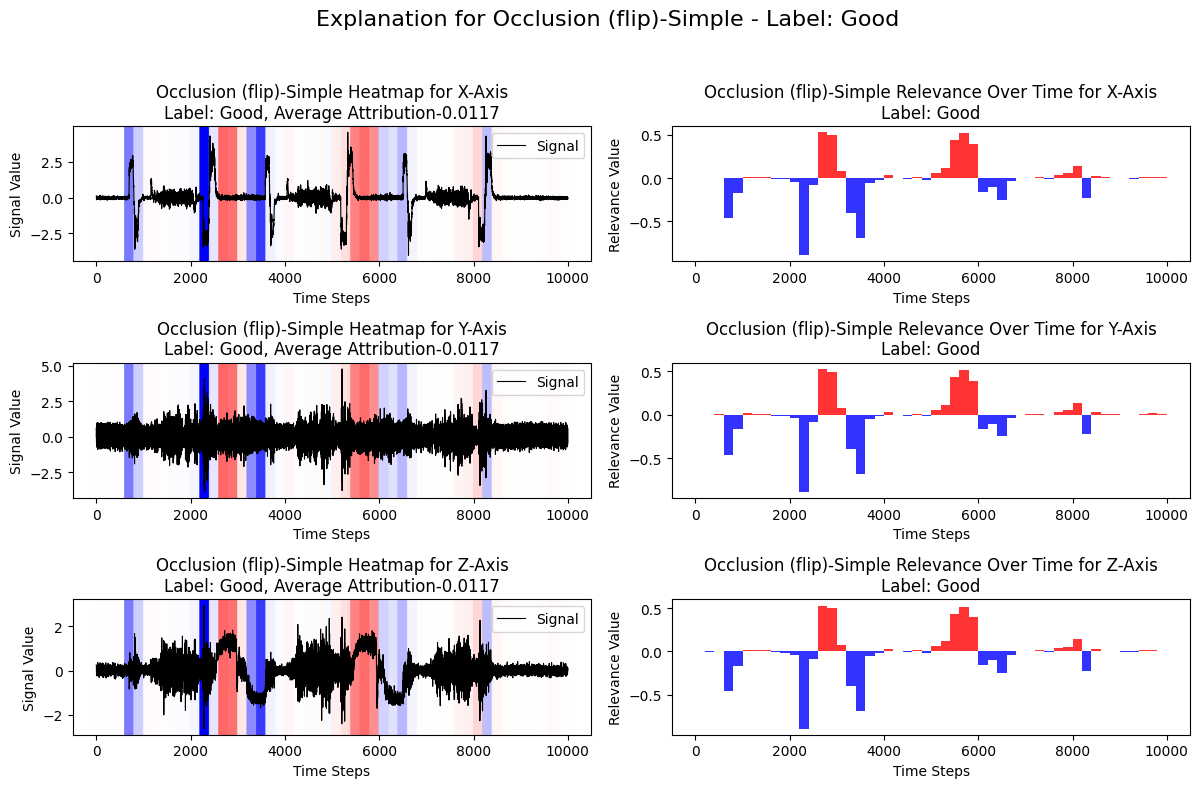

In [96]:
# Occlusion (zero-based occlusion)
occlusion_attr_zero_simple, _ = xai_occlusion_simple(model, sample, occlusion_type="flip")
print(f"Min relevance: {np.min(occlusion_attr_zero_simple.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_zero_simple.detach().cpu().numpy())}")
visualize_combined_with_label_attribution(sample, occlusion_attr_zero_simple, label, "Occlusion (flip)-Simple")


Min relevance: -0.020639419555664062, Max relevance: 0.018884658813476562
 Maximum Absolute Attribution in Axis 0: 0.019783973693847656
 Maximum Absolute Attribution in Axis 1: 0.01884746551513672
 Maximum Absolute Attribution in Axis 2: 0.020639419555664062


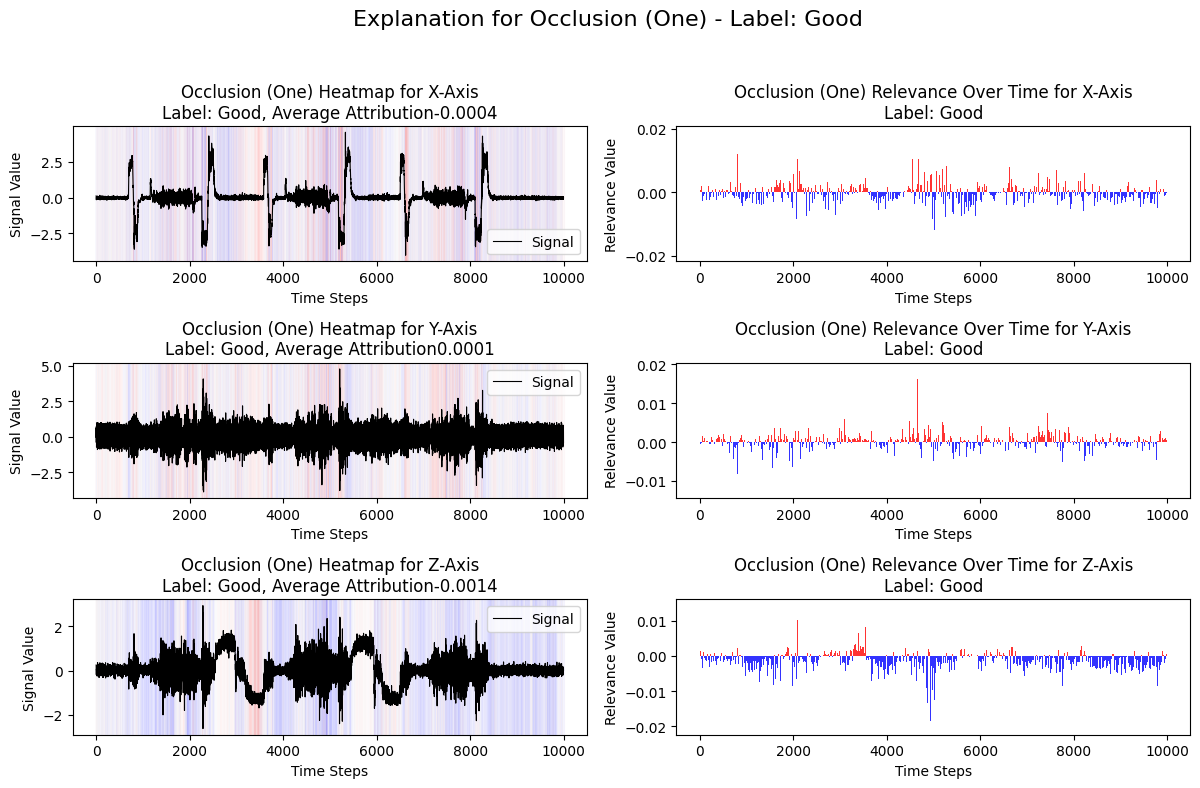

In [76]:
# Occlusion (one occlusion)
occlusion_attr_one, _ = xai_occlusion_signal(model, sample, occlusion_type="one")
print(f"Min relevance: {np.min(occlusion_attr_one.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_one.detach().cpu().numpy())}")
visualize_combined_with_label_attribution(sample, occlusion_attr_one, label, "Occlusion (One)")


Min relevance: -0.019730567932128906, Max relevance: 0.025092124938964844
 Maximum Absolute Attribution in Axis 0: 0.019730567932128906
 Maximum Absolute Attribution in Axis 1: 0.01971721649169922
 Maximum Absolute Attribution in Axis 2: 0.025092124938964844


C:\Users\asadi\AppData\Local\Temp\ipykernel_27372\3560801465.py:76: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title


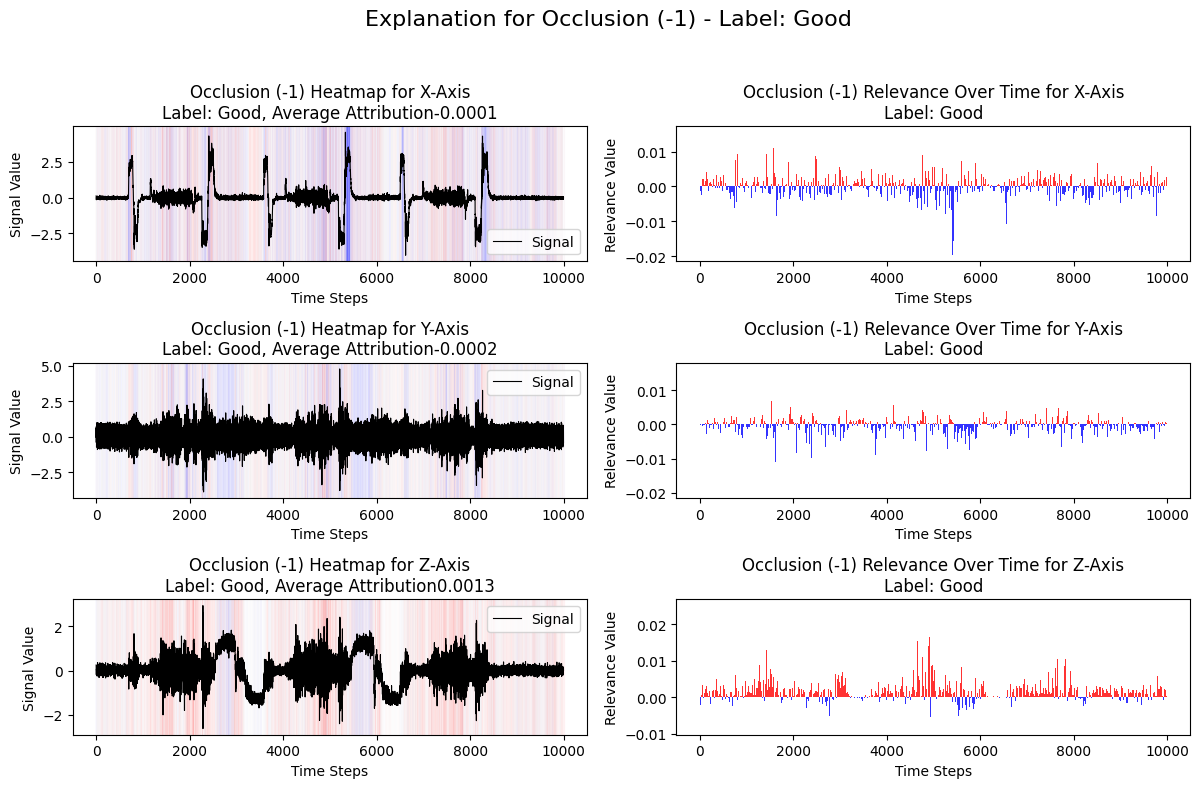

In [77]:
# Occlusion (-one occlusion)
occlusion_attr_mone, _ = xai_occlusion_signal(model, sample, occlusion_type="mone")
print(f"Min relevance: {np.min(occlusion_attr_mone.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_mone.detach().cpu().numpy())}")
visualize_combined_with_label_attribution(sample, occlusion_attr_mone, label, "Occlusion (-1)")


Min relevance: -0.03302192687988281, Max relevance: 0.027923583984375
 Maximum Absolute Attribution in Axis 0: 0.03302192687988281
 Maximum Absolute Attribution in Axis 1: 0.02321147918701172
 Maximum Absolute Attribution in Axis 2: 0.026607513427734375


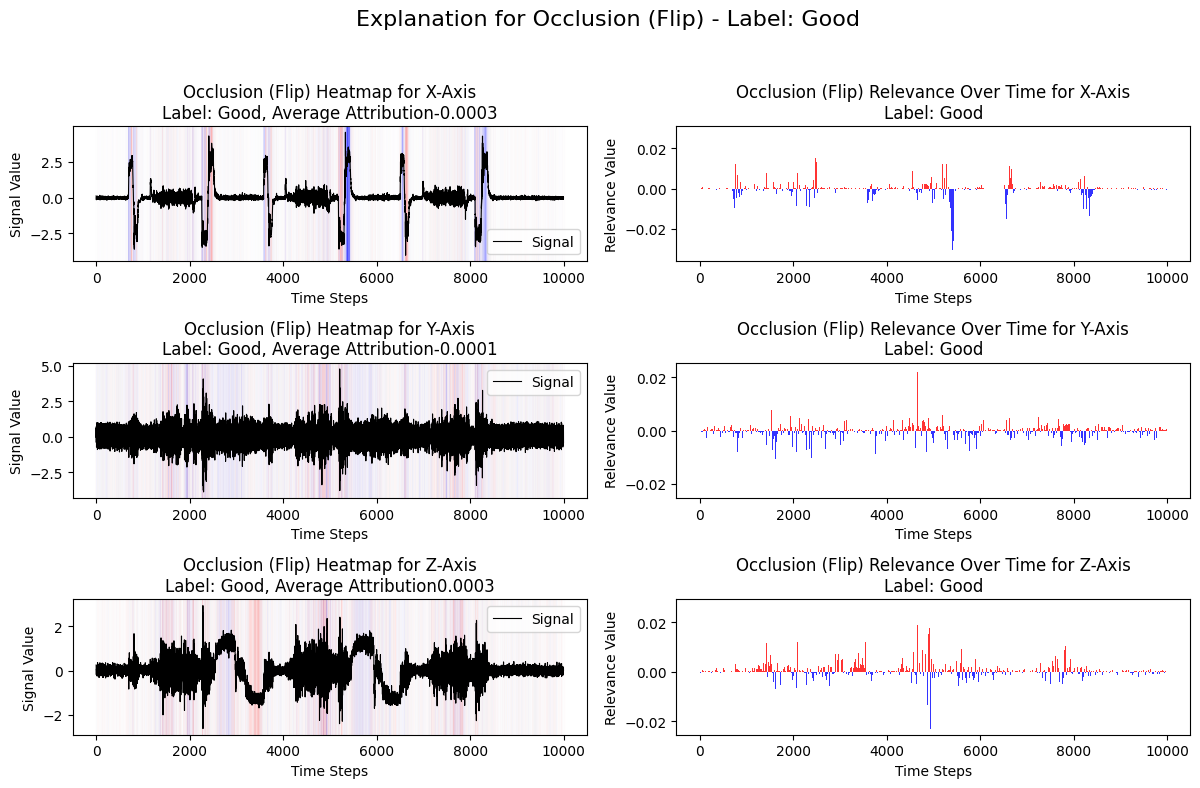

In [78]:
# Occlusion (flip occlusion)
occlusion_attr_flip, _ = xai_occlusion_signal(model, sample, occlusion_type="flip")
print(f"Min relevance: {np.min(occlusion_attr_flip.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_flip.detach().cpu().numpy())}")

visualize_combined_with_label_attribution(sample, occlusion_attr_flip, label, "Occlusion (Flip)")


Min relevance: -0.5555114150047302, Max relevance: 1.3082170486450195
 Maximum Absolute Attribution in Axis 0: 1.179255485534668
 Maximum Absolute Attribution in Axis 1: 1.3082170486450195
 Maximum Absolute Attribution in Axis 2: 0.9775081872940063


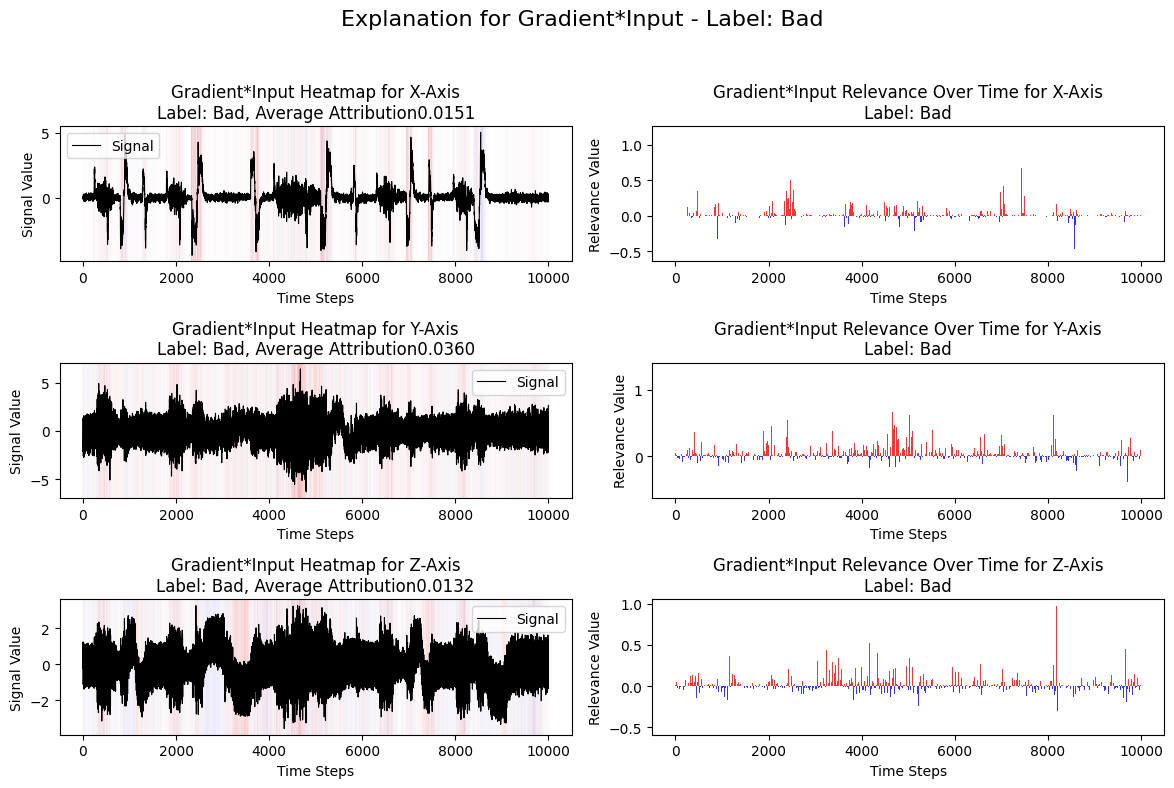

In [79]:
# Grad*Input
grad_input_attr_b, _ = xai_grad_times_input(model, sample_b)
print(f"Min relevance: {np.min(grad_input_attr_b.detach().cpu().numpy())}, Max relevance: {np.max(grad_input_attr_b.detach().cpu().numpy())}")
visualize_combined_with_label_attribution(sample_b, grad_input_attr_b, label_b, "Gradient*Input")

In [80]:
# Example usage
summary_b_g = summarize_attributions(grad_input_attr_b.detach().cpu().numpy())  # Pass your attributions here

# Flatten the summary dictionary and create a DataFrame
data_b_g = []
for axis, values in summary_b_g.items():
    row = {"Axis": axis}
    row.update(values)
    data_b_g.append(row)

# Create the DataFrame
df_summary_b_g = pd.DataFrame(data_b_g)

# Display the DataFrame as a table
print(df_summary_b_g)


     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0            5838                232.067749   
1  Axis 1            6526                476.130707   
2  Axis 2            5045                315.746643   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.039751            4162                -80.667061   
1                    0.072959            3474               -116.615295   
2                    0.062586            4955               -183.481995   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.019382                   151.400696   
1                   -0.033568                   359.515411   
2                   -0.037030                   132.264648   

   Average Relevance (Pos + Neg)  
0                       0.015140  
1                       0.035952  
2                       0.013226  


Min relevance: -2.036717414855957, Max relevance: 5.149232387542725
 Maximum Absolute Attribution in Axis 0: 3.0722312927246094
 Maximum Absolute Attribution in Axis 1: 5.149232387542725
 Maximum Absolute Attribution in Axis 2: 2.6840591430664062


C:\Users\asadi\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


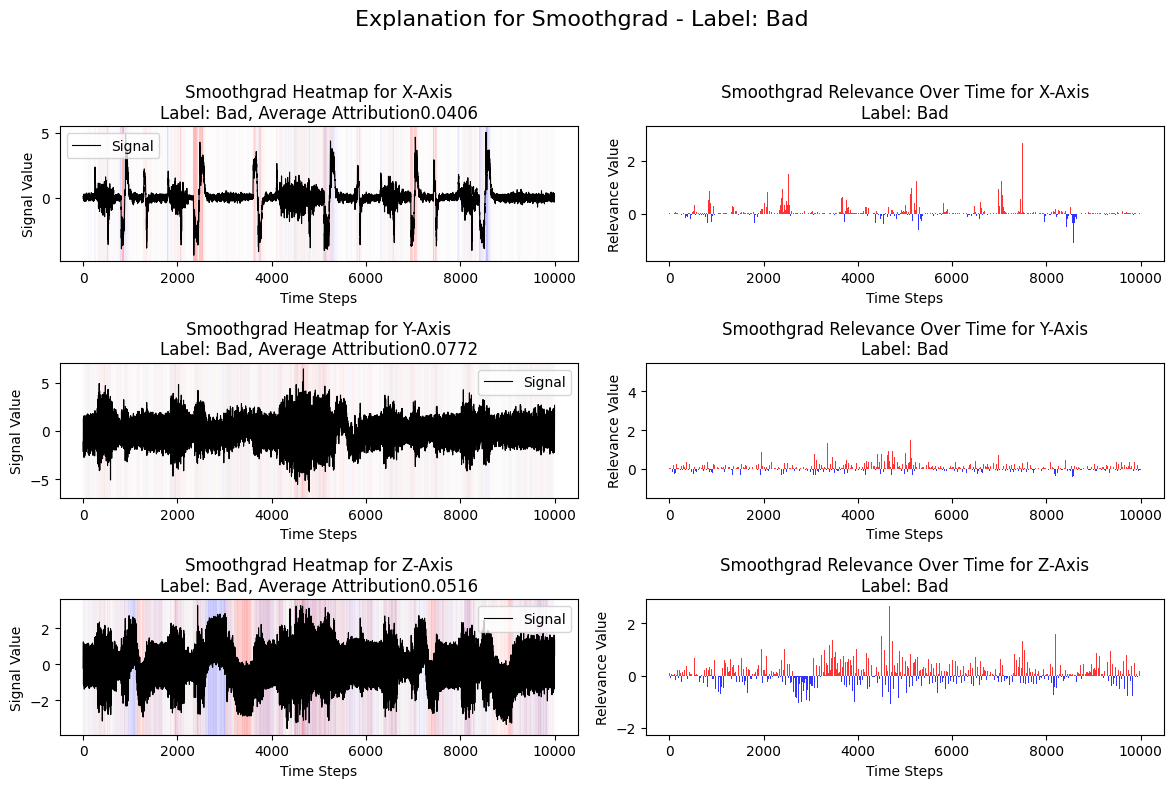

In [81]:
# SmoothGrad
smoothgrad_attr_b, _ = xai_smoothgrad(model, sample_b)
print(f"Min relevance: {np.min(smoothgrad_attr_b.detach().cpu().numpy())}, Max relevance: {np.max(smoothgrad_attr_b.detach().cpu().numpy())}")
visualize_combined_with_label_attribution(sample_b, smoothgrad_attr_b, label_b, "Smoothgrad")


In [82]:
# Example usage
summary_b_sg = summarize_attributions(smoothgrad_attr_b.detach().cpu().numpy())  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_b_sg = []
for axis, values in summary_b_sg.items():
    row = {"Axis": axis}
    row.update(values)
    data_b_sg.append(row)

# Create the DataFrame
df_summary_b_sg = pd.DataFrame(data_b_sg)

# Display the DataFrame as a table
print(df_summary_b_sg)# Flatten the summary dictionary and create a DataFrame


     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0            5709                653.759766   
1  Axis 1            5947               1122.023804   
2  Axis 2            5433               1690.290649   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.114514            4291               -247.772888   
1                    0.188671            4053               -349.618042   
2                    0.311116            4567              -1174.136597   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.057742                   405.986877   
1                   -0.086262                   772.405762   
2                   -0.257091                   516.154053   

   Average Relevance (Pos + Neg)  
0                       0.040599  
1                       0.077241  
2                       0.051615  


Min relevance: -0.026996612548828125, Max relevance: 0.04669952392578125
 Maximum Absolute Attribution in Axis 0: 0.04077339172363281
 Maximum Absolute Attribution in Axis 1: 0.04669952392578125
 Maximum Absolute Attribution in Axis 2: 0.03954505920410156


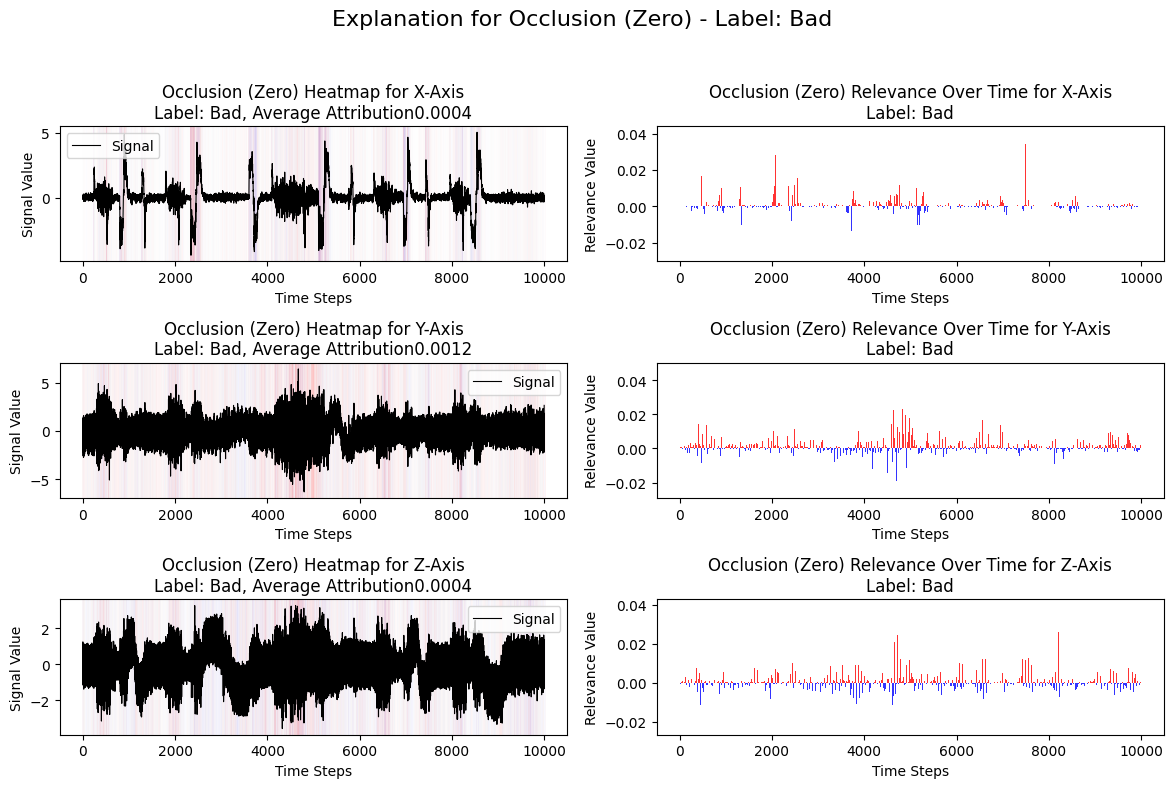

In [83]:
# Occlusion (zero-based occlusion)
occlusion_attr_zero_b, _ = xai_occlusion_signal(model, sample_b, occlusion_type="zero")
print(f"Min relevance: {np.min(occlusion_attr_zero_b.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_zero_b.detach().cpu().numpy())}")
visualize_combined_with_label_attribution(sample_b, occlusion_attr_zero_b, label_b, "Occlusion (Zero)")

Min relevance: -0.039333343505859375, Max relevance: 0.04971885681152344
 Maximum Absolute Attribution in Axis 0: 0.04755210876464844
 Maximum Absolute Attribution in Axis 1: 0.0397491455078125
 Maximum Absolute Attribution in Axis 2: 0.04971885681152344


C:\Users\asadi\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


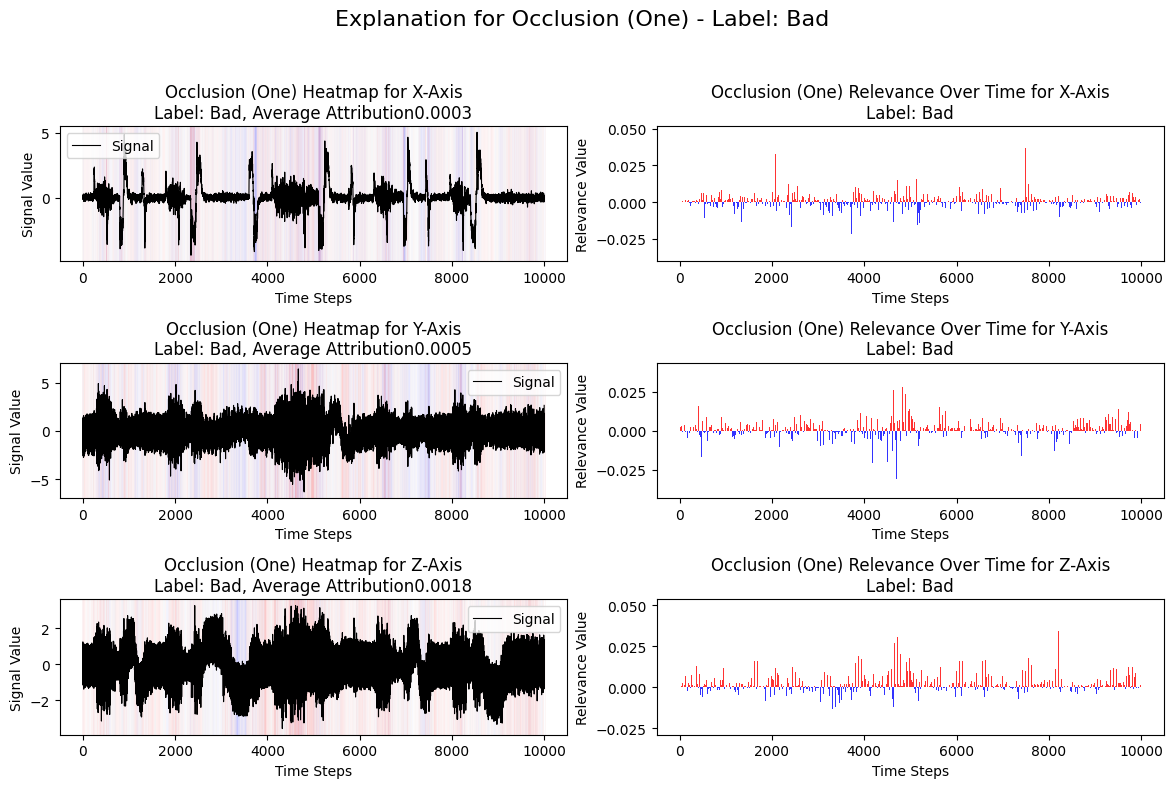

In [84]:
# Occlusion (one occlusion)
occlusion_attr_one_b, _ = xai_occlusion_signal(model, sample_b, occlusion_type="one")
print(f"Min relevance: {np.min(occlusion_attr_one_b.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_one_b.detach().cpu().numpy())}")
visualize_combined_with_label_attribution(sample_b, occlusion_attr_one_b, label_b, "Occlusion (One)")

Min relevance: -0.030801773071289062, Max relevance: 0.05513191223144531
 Maximum Absolute Attribution in Axis 0: 0.034549713134765625
 Maximum Absolute Attribution in Axis 1: 0.05513191223144531
 Maximum Absolute Attribution in Axis 2: 0.030801773071289062


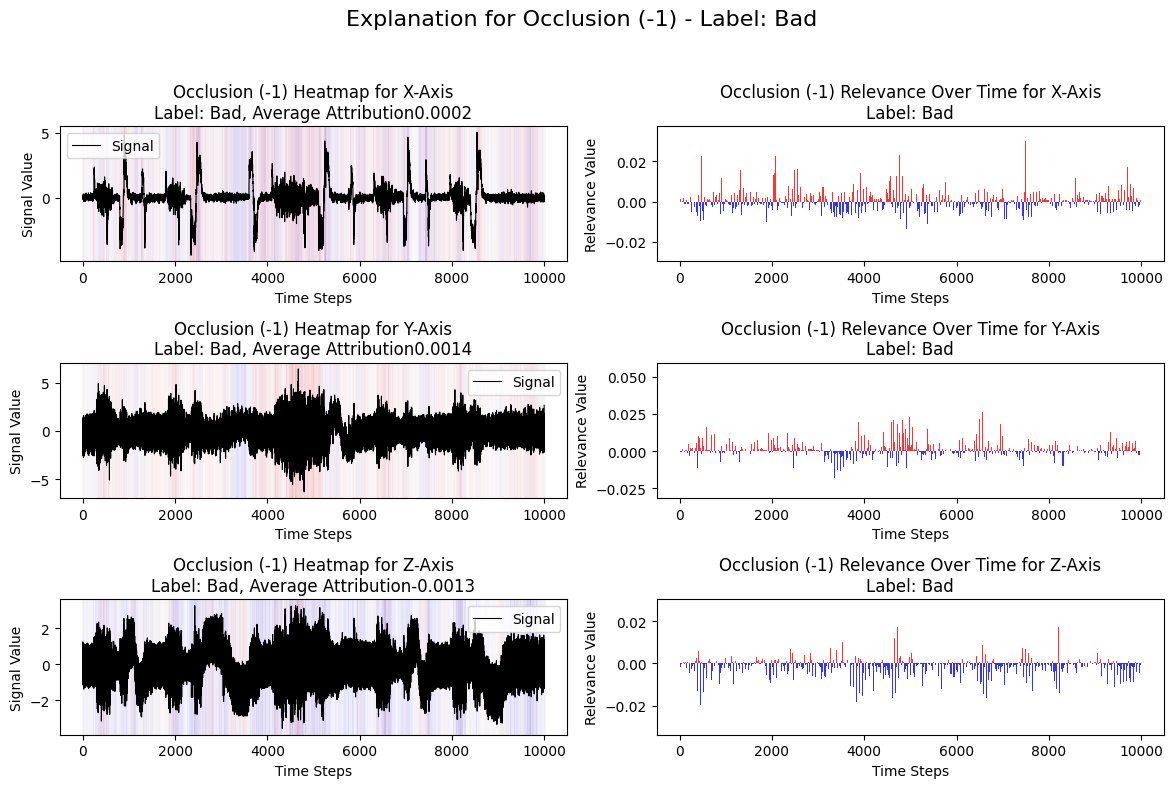

In [85]:
# Occlusion (-one occlusion)
occlusion_attr_mone_b, _ = xai_occlusion_signal(model, sample_b, occlusion_type="mone")
print(f"Min relevance: {np.min(occlusion_attr_mone_b.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_mone_b.detach().cpu().numpy())}")
visualize_combined_with_label_attribution(sample_b, occlusion_attr_mone_b, label_b, "Occlusion (-1)")

Min relevance: -0.058368682861328125, Max relevance: 0.0727996826171875
 Maximum Absolute Attribution in Axis 0: 0.058368682861328125
 Maximum Absolute Attribution in Axis 1: 0.0727996826171875
 Maximum Absolute Attribution in Axis 2: 0.06359672546386719


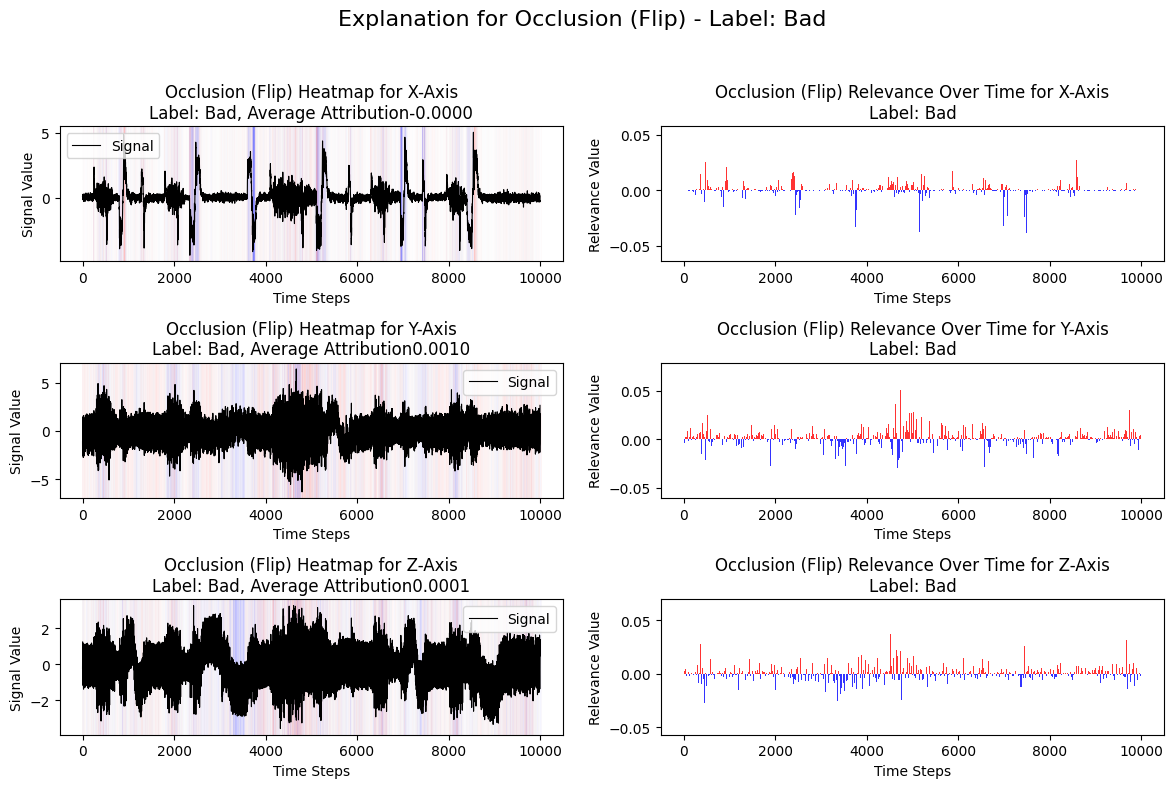

In [86]:

# Occlusion (e.g., zero-based occlusion)
occlusion_attr_flip_b, _ = xai_occlusion_signal(model, sample_b, occlusion_type="flip")
print(f"Min relevance: {np.min(occlusion_attr_flip_b.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_flip_b.detach().cpu().numpy())}")

visualize_combined_with_label_attribution(sample_b, occlusion_attr_flip_b, label_b, "Occlusion (Flip)")


In [89]:
summary_b_of = summarize_attributions(occlusion_attr_flip_b.detach().cpu().numpy())  # Pass your attributions here

# Flatten the summary dictionary and create a DataFrame
data = []
for axis, values in summary_b_of.items():
    row = {"Axis": axis}
    row.update(values)
    data.append(row)

# Create the DataFrame
df_summary = pd.DataFrame(data)

# Display the DataFrame as a table
print(df_summary)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0            5522                 12.449236   
1  Axis 1            5976                 29.622635   
2  Axis 2            4813                 22.623850   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.002254            4456                -12.877113   
1                    0.004957            4016                -19.802704   
2                    0.004701            5180                -21.353970   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.002890                    -0.427877   
1                   -0.004931                     9.819931   
2                   -0.004122                     1.269880   

   Average Relevance (Pos + Neg)  
0                      -0.000043  
1                       0.000983  
2                       0.000127  
